In [9]:
import rocket_casadi
import control
import matplotlib.pyplot as plt
import numpy as np

0 states have been removed from the model
3 states have been removed from the model
4 states have been removed from the model
5.878827146038018 65.09959414250085 39.82722086244476 9.336875158781195
1
max delay 0.12168977738018408 s
gain margin 15.385813818085158 dB
19.19547628723485 1.0220038262310425 71.51492203959857 6.950338746455429e-09
2
max delay 2566397.4644125737 s
gain margin 25.6639778501434 dB
inf 0.16514021686086267 nan 5.1602167534043855e-08
3
max delay 55855.027984589746 s
gain margin inf dB


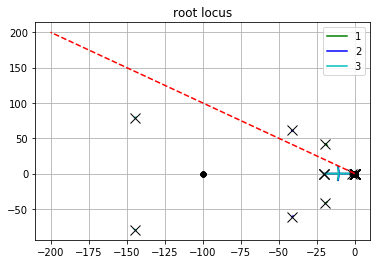

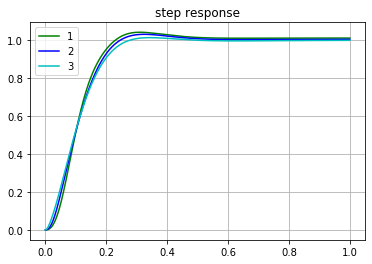

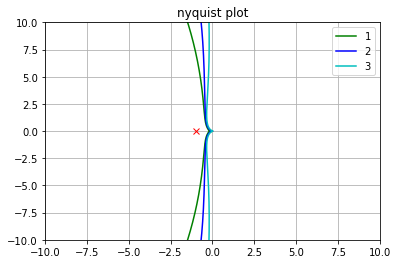

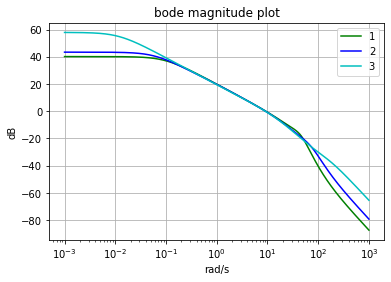

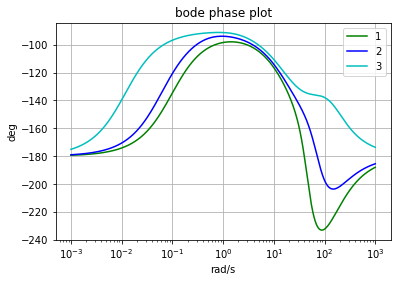

In [35]:
trim_points = [
    {'vt': 100, 'gamma_deg': 90, 'm_fuel': 0.8, 'color':'g', 'name':'1'},
    {'vt': 150, 'gamma_deg': 45, 'm_fuel': 0.5, 'color':'b', 'name':'2'},
    {'vt': 300, 'gamma_deg': 0, 'm_fuel': 0.2, 'color': 'c', 'name':'3'},
]

s = control.tf([1, 0], [0, 1])

# One Controller to rule them all, One Controller to find them,
# One Controller to bring them all, and in the rocket bind them
H = 10*(s/100+1)*(s/100+1)/s*(20/(s+20))


Go_list = []
for trim_point in trim_points:
    
    vt = trim_point['vt']
    gamma_deg = trim_point['gamma_deg']
    m_fuel = trim_point['m_fuel']

    x0, u0, p0 = rocket_casadi.do_trim(vt=vt, gamma_deg=gamma_deg, m_fuel=m_fuel)
    sys = control.ss(*rocket_casadi.linearize()(x0, u0, p0))

    G = sys[1, 2]/s;
    Go = control.minreal(G*H)
    Go_list.append(Go)

plt.figure()
plt.title('root locus')
handles = []
names = []
for trim_point, Go in zip(trim_points, Go_list):
    locus, omega = control.rlocus(Go, kvect=np.linspace(0, 1, 1000), Plot=False)
    handles.append(plt.plot(np.real(locus), np.imag(locus), color=trim_point['color'])[0])
    names.append(trim_point['name'])
    plt.plot(np.real(control.pole(Go)), np.imag(control.pole(Go)), 'kx', markersize='10')
    plt.plot(np.real(control.zero(Go)), np.imag(control.zero(Go)), 'ko', markersize='5')
plt.legend(handles, names)
plt.grid() 
plt.plot([0, -200], [0, 200], 'r--')

plt.figure()
plt.title('step response')
for trim_point, Go in zip(trim_points, Go_list):
    Gc = control.feedback(Go)
    t, y = control.step_response(Gc, T=np.linspace(0, 1, 1000))
    plt.plot(t, y, trim_point['color'], label=trim_point['name'])
plt.grid()
plt.legend()

plt.figure()
plt.title('nyquist plot')
for trim_point, Go in zip(trim_points, Go_list):
    real, imag, freq = control.nyquist(Go, omega=np.logspace(-3, 3, 1000), Plot=False)
    plt.plot(real, imag, trim_point['color'])
    plt.plot(real, -imag, trim_point['color'], label=trim_point['name'])
plt.plot(-1, 0, 'rx')
plt.grid()
plt.axis([-10, 10, -10, 10])
plt.legend()

plt.figure()
plt.title('bode magnitude plot')
for trim_point, Go in zip(trim_points, Go_list):
    mag, phase, omega = control.bode(Go, omega=np.logspace(-3, 3, 1000), Plot=False)
    plt.semilogx(omega, 20*np.log10(mag), trim_point['color'], label=trim_point['name'])
plt.xlabel('rad/s')
plt.ylabel('dB')
plt.grid()
plt.legend()

plt.figure()
plt.title('bode phase plot')
for trim_point, Go in zip(trim_points, Go_list):
    mag, phase, omega = control.bode(Go, omega=np.logspace(-3, 3, 1000), Plot=False)
    plt.semilogx(omega, np.rad2deg(phase), trim_point['color'], label=trim_point['name'])
plt.xlabel('rad/s')
plt.ylabel('deg')
plt.grid()
plt.legend()

for trim_point, Go in zip(trim_points, Go_list):
    gm, pm, wg, wp = control.margin(Go)
    print(gm, pm, wg, wp)
    print(trim_point['name'])
    print('max delay', np.deg2rad(pm)/wp, 's')
    print('gain margin', 20*np.log10(gm), 'dB')

In [36]:
s = control.tf([1, 0], [0, 1])
H = 10*(s/100+1)*(s/100+1)/s*(20/(s+3))
Hd = control.tf2ss(control.c2d(H, 0.01))
Hd

x = ca.SX.sym('x', 2)
u = ca.SX.sym('u', 1)
x1 = ca.mtimes(Hd.A, x) + ca.mtimes(Hd.B, u)
y = ca.mtimes(Hd.C, x) + ca.mtimes(Hd.D, u)

f_control = ca.Function('control', [x, u], [x1, y], ['x', 'u'], ['x1', 'y'])
f_control

NameError: name 'ca' is not defined